<a href="https://colab.research.google.com/github/lynchlee1/Salage/blob/main/MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data upload section
input_data_PATH  = '/content/drive/MyDrive/toy project/데이터/64man_inputs.csv'
output_data_PATH = '/content/drive/MyDrive/toy project/데이터/64man_outputs.csv'
preNN_PATH = '/content/drive/MyDrive/toy project/데이터/LGD Project/LEEv1.pt'

In [13]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [14]:
# Variable section
r=1

len_data = 2000 # length of data to read
batch_size = int(64)

# negative: custom function
# -1: all distort
# -2: h3 distort
do_data_distort = 2 # 0: None(or pre-train), 1: h3 single distort, 2: all distort, 3: h1 single distort, 4: h2 single distort, 5: h4 single distort

type_tNet = 2 # 1: Four 100*100 layers, 2: Two 100*100 layers, 3: Four 50*50 layers, 4: Three 100*100 layers, 5: Four 30*30 layers,
fully_connected = 0 # 0: Not fully connected, 1: Fully connected

# Subvariable section
n_distort_show = 6
criterion = nn.MSELoss()
device = 'cpu'

In [15]:
def myfun(x):
  y = np.sqrt(x)
  return y

def amyfun(x):
  y = np.square(x)
  return y

myfun_v = np.vectorize(myfun)

In [16]:
input = np.array(pd.read_csv(input_data_PATH, header=None, nrows=len_data, skiprows=100000))
input = torch.Tensor(input)

output   = np.array(pd.read_csv(output_data_PATH, header=None, nrows=len_data, skiprows=100000))
output = torch.Tensor(output)

torch.set_printoptions(sci_mode=True)
print('Input is...')
for i in range(n_distort_show): print(input[i,:])



if do_data_distort != 0:
  print('\nDistorted input is...')

if do_data_distort == -1:
  h_var = input[:,0:4]
  n_var = input[:,4:6]
  h_var = torch.FloatTensor(myfun_v(h_var))

  input = torch.cat((h_var,n_var),1)

  print(input[0:n_distort_show,:])  

if do_data_distort == -2:
  front = input[:,0:2]
  mid   = input[:,2:3]
  back  = input[:,3:6]
  mid = torch.FloatTensor(myfun_v(mid))

  input = torch.cat((front,mid,back),1)
  for i in range(n_distort_show): print(input[i,:])

if do_data_distort == -3:
  front = input[:,0:2]
  mid1   = input[:,2:3]
  mid2   = input[:,3:4]
  back  = input[:,4:6]

  mid1 = torch.FloatTensor(myfun_v(mid1))
  mid2 = torch.FloatTensor(myfun_v(mid2))

  input = torch.cat((front,mid1,mid2,back),1)
  for i in range(n_distort_show): print(input[i,:])

if do_data_distort == 1:
  front = input[:,0:2]
  mid   = input[:,2:3]
  back  = input[:,3:6]
  mid = torch.square(mid)

  input = torch.cat((front,mid,back),1)
  for i in range(n_distort_show): print(input[i,:])

if do_data_distort == 2:
  h_var = input[:,0:4]
  n_var = input[:,4:6]
  h_var = torch.square(h_var)

  input = torch.cat((h_var,n_var),1)
  for i in range(n_distort_show): print(input[i,:])

if do_data_distort == 3:
  front = input[:,0:1]
  back  = input[:,1:6]
  front = torch.square(front)

  input = torch.cat((front,back),1)
  for i in range(n_distort_show): print(input[i,:])

if do_data_distort == 4:
  front = input[:,0:1]
  mid   = input[:,1:2]
  back  = input[:,2:6]
  mid = torch.square(mid)

  input = torch.cat((front,mid,back),1)
  for i in range(n_distort_show): print(input[i,:])

if do_data_distort == 5:
  front = input[:,0:3]
  mid   = input[:,3:4]
  back  = input[:,4:6]
  mid = torch.square(mid)

  input = torch.cat((front,mid,back),1)
  for i in range(n_distort_show): print(input[i,:])

Input is...
tensor([5.5789e-01, 8.2268e-01, 2.9159e-01, 2.8634e-01, 8.7753e-01, 4.8819e-02])
tensor([1.8428e-01, 8.1901e-01, 9.7393e-02, 1.8173e-01, 6.3006e-01, 3.8485e-01])
tensor([8.7323e-02, 5.2606e-01, 7.3805e-01, 1.1024e-01, 6.2367e-01, 7.0853e-01])
tensor([2.7008e-01, 6.7212e-03, 1.9836e-01, 5.0909e-01, 2.5333e-01, 1.7870e-01])
tensor([5.4928e-01, 6.7925e-01, 5.9287e-01, 9.6958e-02, 5.5564e-01, 3.9925e-01])
tensor([2.8366e-01, 5.2116e-02, 7.4260e-01, 9.3541e-01, 7.3818e-02, 7.4617e-01])

Distorted input is...
tensor([3.1124e-01, 6.7681e-01, 8.5023e-02, 8.1990e-02, 8.7753e-01, 4.8819e-02])
tensor([3.3960e-02, 6.7078e-01, 9.4854e-03, 3.3026e-02, 6.3006e-01, 3.8485e-01])
tensor([7.6252e-03, 2.7674e-01, 5.4471e-01, 1.2152e-02, 6.2367e-01, 7.0853e-01])
tensor([7.2945e-02, 4.5174e-05, 3.9346e-02, 2.5917e-01, 2.5333e-01, 1.7870e-01])
tensor([3.0171e-01, 4.6138e-01, 3.5149e-01, 9.4009e-03, 5.5564e-01, 3.9925e-01])
tensor([8.0462e-02, 2.7160e-03, 5.5145e-01, 8.7498e-01, 7.3818e-02, 7.4617

In [17]:
class pNet(nn.Module):
  def __init__(self):
    super(pNet, self).__init__()
    self.fc1 = nn.Linear(6, 300)
    self.fc2 = nn.Linear(300, 300)
    self.fc3 = nn.Linear(300, 300)
    self.fc4 = nn.Linear(300, 300)
    self.fc5 = nn.Linear(300, 300)
    self.fc6 = nn.Linear(300, 300)
    self.fc7 = nn.Linear(300, 300)
    self.fc8 = nn.Linear(300, 300)
    self.fc9 = nn.Linear(300, 300)
    self.fc10 = nn.Linear(300, 300)
    self.fc11 = nn.Linear(300,81)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    x = F.leaky_relu(self.fc4(x))
    x = F.leaky_relu(self.fc5(x))
    x = F.leaky_relu(self.fc6(x))
    x = F.leaky_relu(self.fc7(x))
    x = F.leaky_relu(self.fc8(x))
    x = F.leaky_relu(self.fc9(x))
    x = F.leaky_relu(self.fc10(x))
    return self.fc11(x)

n_node = 0
if fully_connected == 0:
  n_node = 1
if fully_connected == 1:
  if do_data_distort != 2:
    print("Warning: Not all four variables are distorted, but connected to transfer layer.")
  n_node = 4

if type_tNet == 1:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 100)
      self.fc2 = nn.Linear(100, 100)
      self.fc3 = nn.Linear(100, 100)
      self.fc4 = nn.Linear(100, 100)
      self.fc5 = nn.Linear(100,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = F.leaky_relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x

if type_tNet == 2:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 100)
      self.fc2 = nn.Linear(100, 100)
      self.fc3 = nn.Linear(100,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = torch.sigmoid(self.fc3(x))
      return x

if type_tNet == 3:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 50)
      self.fc2 = nn.Linear(50, 50)
      self.fc3 = nn.Linear(50, 50)
      self.fc4 = nn.Linear(50, 50)
      self.fc5 = nn.Linear(50,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = F.leaky_relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x

if type_tNet == 4:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 100)
      self.fc2 = nn.Linear(100, 100)
      self.fc3 = nn.Linear(100, 100)
      self.fc4 = nn.Linear(100,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = torch.sigmoid(self.fc4(x))
      return x

if type_tNet == 5:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 30)
      self.fc2 = nn.Linear(30, 30)
      self.fc3 = nn.Linear(30, 30)
      self.fc4 = nn.Linear(30, 30)
      self.fc5 = nn.Linear(30,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = F.leaky_relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x

modelPre = pNet()
modelPre.load_state_dict(torch.load(preNN_PATH,map_location=torch.device('cpu')))
for param in modelPre.parameters():
  param.requires_grad = False

if do_data_distort == -1 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h1_tNet = tNet()
      self.h2_tNet = tNet()
      self.h3_tNet = tNet()
      self.h4_tNet = tNet()

    def forward(self,hstar):
      h1 = self.h1_tNet(hstar[:,0:1])
      h2 = self.h2_tNet(hstar[:,1:2])
      h3 = self.h3_tNet(hstar[:,2:3])
      h4 = self.h4_tNet(hstar[:,3:4])
      hcat = torch.cat((h1,h2,h3,h4),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if do_data_distort == -2 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h3_tNet = tNet()

    def forward(self,hstar):
      h3 = self.h3_tNet(hstar[:,2:3])
      hcat = torch.cat((hstar[:,0:2],h3,hstar[:,3:4]),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if do_data_distort == -3 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h3_tNet = tNet()
      self.h4_tNet = tNet()

    def forward(self,hstar):
      h3 = self.h3_tNet(hstar[:,2:3])
      h4 = self.h4_tNet(hstar[:,3:4])
      hcat = torch.cat((hstar[:,0:2],h3,h4),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if do_data_distort == 1 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h3_tNet = tNet()

    def forward(self,hstar):
      h3 = self.h3_tNet(hstar[:,2:3])
      hcat = torch.cat((hstar[:,0:2],h3,hstar[:,3:4]),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if do_data_distort == 2 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h1_tNet = tNet()
      self.h2_tNet = tNet()
      self.h3_tNet = tNet()
      self.h4_tNet = tNet()

    def forward(self,hstar):
      h1 = self.h1_tNet(hstar[:,0:1])
      h2 = self.h2_tNet(hstar[:,1:2])
      h3 = self.h3_tNet(hstar[:,2:3])
      h4 = self.h4_tNet(hstar[:,3:4])
      hcat = torch.cat((h1,h2,h3,h4),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if do_data_distort == 3 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h1_tNet = tNet()

    def forward(self,hstar):
      h1 = self.h1_tNet(hstar[:,0:1])
      hcat = torch.cat((h1,hstar[:,1:4]),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if do_data_distort == 4 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h2_tNet = tNet()

    def forward(self,hstar):
      h2 = self.h2_tNet(hstar[:,1:2])
      hcat = torch.cat((hstar[:,0:1],h2,hstar[:,2:4]),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if do_data_distort == 5 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h4_tNet = tNet()

    def forward(self,hstar):
      h4 = self.h4_tNet(hstar[:,3:4])
      hcat = torch.cat((hstar[:,0:3],h4),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if fully_connected == 1:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.subNet = tNet()
    
    def forward(self,hstar):
      h = self.subNet(hstar[:,0:4])
      h = torch.cat((h,hstar[:,4:6]),1)
      h = modelPre(h)
      return h

print(Net())

Net(
  (h1_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
  (h2_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
  (h3_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
  (h4_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(input, output, test_size=0.2, shuffle=True, random_state=34)

dataset_train = TensorDataset(x_train, y_train)
dataset_test = TensorDataset(x_valid, y_valid)

# Shuffle argument controls data shuffling for stochastic gradient descent
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print('\nThis is trainset')
print(dataset_train[0])
print('\nThis is testset')
print(dataset_test[0])


This is trainset
(tensor([2.1638e-03, 2.2997e-01, 3.8159e-01, 9.0425e-01, 9.0644e-01, 2.5185e-02]), tensor([2.1654e-01, 2.1417e-01, 2.1170e-01, 2.1000e-01, 2.0931e-01, 2.1190e-01, 2.4292e-01, 2.7626e-01, 2.5331e-01,
        2.2340e-01, 1.9968e-01, 1.8831e-01, 1.8685e-01, 1.8922e-01, 1.9627e-01, 2.0817e-01, 2.2213e-01, 2.3797e-01,
        2.5075e-01, 2.6160e-01, 2.7134e-01, 2.8160e-01, 2.9071e-01, 2.9762e-01, 3.0574e-01, 3.1137e-01, 3.1687e-01,
        3.2114e-01, 3.2349e-01, 3.2435e-01, 3.2417e-01, 3.2342e-01, 3.2202e-01, 3.1644e-01, 3.0812e-01, 2.9884e-01,
        2.8946e-01, 2.8049e-01, 2.7302e-01, 2.6669e-01, 2.6190e-01, 2.5821e-01, 2.5552e-01, 2.5330e-01, 2.5162e-01,
        2.5008e-01, 2.4874e-01, 2.4748e-01, 2.4639e-01, 2.4522e-01, 2.4401e-01, 2.4282e-01, 2.4164e-01, 2.4040e-01,
        2.3939e-01, 2.3873e-01, 2.3826e-01, 2.3815e-01, 2.3857e-01, 2.3917e-01, 2.3908e-01, 2.3750e-01, 2.3461e-01,
        2.3061e-01, 2.2609e-01, 2.2103e-01, 2.1560e-01, 2.1000e-01, 2.0415e-01, 1.9811e

In [19]:
def train(model, device, train_loader, optimizer, criterion):
    # The layers of our model which uses dropout, batch-normalization should behave differently depending on the current phase(training or evaluation)
    model.train() # training mode 
    
    losses_batch = []

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
        optimizer.zero_grad()             # clear out the gradients to avoid accumulating with the gradients computed in previous step. 
        outputs = model(inputs)           # 1) Proceed forward pass
        loss = criterion(outputs, labels) # 2) Compute the loss by comparing the predictive outputs and the actual labels
        losses_batch.append(loss)
        loss.backward()                   # 3) Compute a gradient of a loss function by backpropagation
        optimizer.step()                  # 4) Update the weight by gradient descent according to the method(SGD or SGD with momentum or Adam) we defined earlier

    loss_epoch = sum(losses_batch)/len(losses_batch)

    return loss_epoch

def eval(model, device, test_loader):
     
    model.eval() # evaluation mode
    total = 0
    correct = 0
    losses_batch = []

    with torch.no_grad(): # Deactivate the autograd engine # Note that in testing time, we don't need the gradient.
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
            outputs = model(inputs)                               # Obtain the outputs from model

            #print(outputs.shape)    #(64,81)
            #print(labels.shape)     #(64,81)
            loss = criterion(outputs, labels)
            losses_batch.append(loss)

    loss_epoch = sum(losses_batch)/len(losses_batch)

    print('loss epoch: {:.8f}'.format(loss_epoch))
    return loss_epoch

In [20]:
torch.manual_seed(2020) # Sets the seed for reproducibility

train_loss_epoch = []
test_acc_epoch = []

In [21]:
#Make a model defined above
model1 = Net()
model1.to(device) # Move our model to gpu if we can use gpu
print(':model1 is:')
print(model1)

#Choose an optimizer for you to use and set learning rate
num_epoch = 200
optimizer = optim.Adam(model1.parameters(), lr=0.003*r, betas = (0.9,0.999),eps = 1e-08, weight_decay =0, amsgrad = False)
for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model1, device, train_loader, optimizer, criterion))
    test_acc_epoch.append(eval(model1, device, test_loader))

num_epoch = 100
optimizer = optim.Adam(model1.parameters(), lr=0.0001*r, betas = (0.9,0.999),eps = 1e-08, weight_decay =0, amsgrad = False)
for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model1, device, train_loader, optimizer, criterion))
    test_acc_epoch.append(eval(model1, device, test_loader))

:model1 is:
Net(
  (h1_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
  (h2_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
  (h3_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
  (h4_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=1, bias=True)
  )
)


  0%|          | 1/200 [00:00<01:19,  2.50it/s]

loss epoch: 0.01177302


  1%|          | 2/200 [00:00<01:05,  3.02it/s]

loss epoch: 0.01106501


  2%|▏         | 3/200 [00:00<01:02,  3.16it/s]

loss epoch: 0.01068743


  2%|▏         | 4/200 [00:01<00:59,  3.30it/s]

loss epoch: 0.01047551


  2%|▎         | 5/200 [00:01<00:58,  3.33it/s]

loss epoch: 0.01017192


  3%|▎         | 6/200 [00:01<00:59,  3.26it/s]

loss epoch: 0.01007573


  4%|▎         | 7/200 [00:02<00:58,  3.30it/s]

loss epoch: 0.00985871


  4%|▍         | 8/200 [00:02<00:57,  3.36it/s]

loss epoch: 0.00962477


  4%|▍         | 9/200 [00:02<00:56,  3.38it/s]

loss epoch: 0.00965179


  5%|▌         | 10/200 [00:03<00:56,  3.37it/s]

loss epoch: 0.00949673


  6%|▌         | 11/200 [00:03<00:56,  3.37it/s]

loss epoch: 0.00965486


  6%|▌         | 12/200 [00:03<00:53,  3.49it/s]

loss epoch: 0.00969991


  6%|▋         | 13/200 [00:03<00:53,  3.52it/s]

loss epoch: 0.00974437


  7%|▋         | 14/200 [00:04<00:52,  3.54it/s]

loss epoch: 0.00937370


  8%|▊         | 15/200 [00:04<00:51,  3.57it/s]

loss epoch: 0.00975924


  8%|▊         | 16/200 [00:04<00:51,  3.59it/s]

loss epoch: 0.00939687


  8%|▊         | 17/200 [00:05<00:51,  3.57it/s]

loss epoch: 0.00934651


  9%|▉         | 18/200 [00:05<00:51,  3.51it/s]

loss epoch: 0.00944153


 10%|▉         | 19/200 [00:05<00:51,  3.55it/s]

loss epoch: 0.00934133


 10%|█         | 20/200 [00:05<00:50,  3.55it/s]

loss epoch: 0.00926651


 10%|█         | 21/200 [00:06<00:50,  3.55it/s]

loss epoch: 0.00921401


 11%|█         | 22/200 [00:06<00:49,  3.63it/s]

loss epoch: 0.00932315


 12%|█▏        | 23/200 [00:06<00:48,  3.62it/s]

loss epoch: 0.00924440


 12%|█▏        | 24/200 [00:06<00:49,  3.58it/s]

loss epoch: 0.00936976


 12%|█▎        | 25/200 [00:07<00:48,  3.58it/s]

loss epoch: 0.00928819


 13%|█▎        | 26/200 [00:07<00:48,  3.60it/s]

loss epoch: 0.00926887


 14%|█▎        | 27/200 [00:07<00:48,  3.60it/s]

loss epoch: 0.00919428


 14%|█▍        | 28/200 [00:08<00:47,  3.60it/s]

loss epoch: 0.00952330


 14%|█▍        | 29/200 [00:08<00:47,  3.58it/s]

loss epoch: 0.00915501


 15%|█▌        | 30/200 [00:08<00:46,  3.62it/s]

loss epoch: 0.00935154


 16%|█▌        | 31/200 [00:08<00:47,  3.59it/s]

loss epoch: 0.00933766


 16%|█▌        | 32/200 [00:09<00:47,  3.54it/s]

loss epoch: 0.00913946


 16%|█▋        | 33/200 [00:09<00:47,  3.55it/s]

loss epoch: 0.00905451


 17%|█▋        | 34/200 [00:09<00:46,  3.56it/s]

loss epoch: 0.00906927


 18%|█▊        | 35/200 [00:10<00:46,  3.57it/s]

loss epoch: 0.00900942


 18%|█▊        | 36/200 [00:10<00:46,  3.56it/s]

loss epoch: 0.00889860


 18%|█▊        | 37/200 [00:10<00:45,  3.55it/s]

loss epoch: 0.00882403


 19%|█▉        | 38/200 [00:10<00:45,  3.58it/s]

loss epoch: 0.00909343


 20%|█▉        | 39/200 [00:11<00:44,  3.59it/s]

loss epoch: 0.00874803


 20%|██        | 40/200 [00:11<00:44,  3.58it/s]

loss epoch: 0.00878227


 20%|██        | 41/200 [00:11<00:44,  3.61it/s]

loss epoch: 0.00880032


 21%|██        | 42/200 [00:11<00:43,  3.60it/s]

loss epoch: 0.00878688


 22%|██▏       | 43/200 [00:12<00:44,  3.57it/s]

loss epoch: 0.00881941


 22%|██▏       | 44/200 [00:12<00:43,  3.62it/s]

loss epoch: 0.00924414


 22%|██▎       | 45/200 [00:12<00:42,  3.61it/s]

loss epoch: 0.00874175


 23%|██▎       | 46/200 [00:13<00:42,  3.62it/s]

loss epoch: 0.00885892


 24%|██▎       | 47/200 [00:13<00:42,  3.58it/s]

loss epoch: 0.00881654


 24%|██▍       | 48/200 [00:13<00:44,  3.42it/s]

loss epoch: 0.00863925


 24%|██▍       | 49/200 [00:13<00:43,  3.46it/s]

loss epoch: 0.00868766


 25%|██▌       | 50/200 [00:14<00:43,  3.48it/s]

loss epoch: 0.00880112


 26%|██▌       | 51/200 [00:14<00:42,  3.48it/s]

loss epoch: 0.00870689


 26%|██▌       | 52/200 [00:14<00:42,  3.51it/s]

loss epoch: 0.00861780


 26%|██▋       | 53/200 [00:15<00:42,  3.47it/s]

loss epoch: 0.00884517


 27%|██▋       | 54/200 [00:15<00:41,  3.51it/s]

loss epoch: 0.00884963


 28%|██▊       | 55/200 [00:15<00:41,  3.53it/s]

loss epoch: 0.00883075


 28%|██▊       | 56/200 [00:15<00:40,  3.55it/s]

loss epoch: 0.00861237


 28%|██▊       | 57/200 [00:16<00:39,  3.59it/s]

loss epoch: 0.00889603


 29%|██▉       | 58/200 [00:16<00:39,  3.60it/s]

loss epoch: 0.00880599


 30%|██▉       | 59/200 [00:16<00:39,  3.58it/s]

loss epoch: 0.00879523


 30%|███       | 60/200 [00:17<00:38,  3.61it/s]

loss epoch: 0.00863171


 30%|███       | 61/200 [00:17<00:38,  3.64it/s]

loss epoch: 0.00889986


 31%|███       | 62/200 [00:17<00:38,  3.61it/s]

loss epoch: 0.00867775


 32%|███▏      | 63/200 [00:17<00:37,  3.64it/s]

loss epoch: 0.00896841


 32%|███▏      | 64/200 [00:18<00:37,  3.64it/s]

loss epoch: 0.00883702


 32%|███▎      | 65/200 [00:18<00:37,  3.62it/s]

loss epoch: 0.00884061


 33%|███▎      | 66/200 [00:18<00:36,  3.64it/s]

loss epoch: 0.00880673


 34%|███▎      | 67/200 [00:18<00:36,  3.63it/s]

loss epoch: 0.00886664


 34%|███▍      | 68/200 [00:19<00:36,  3.63it/s]

loss epoch: 0.00865931


 34%|███▍      | 69/200 [00:19<00:36,  3.61it/s]

loss epoch: 0.00871421


 35%|███▌      | 70/200 [00:19<00:35,  3.61it/s]

loss epoch: 0.00885163


 36%|███▌      | 71/200 [00:20<00:35,  3.61it/s]

loss epoch: 0.00848649


 36%|███▌      | 72/200 [00:20<00:35,  3.64it/s]

loss epoch: 0.00851718


 36%|███▋      | 73/200 [00:20<00:35,  3.59it/s]

loss epoch: 0.00834638


 37%|███▋      | 74/200 [00:20<00:34,  3.61it/s]

loss epoch: 0.00847023


 38%|███▊      | 75/200 [00:21<00:34,  3.63it/s]

loss epoch: 0.00839909


 38%|███▊      | 76/200 [00:21<00:34,  3.63it/s]

loss epoch: 0.00852765


 38%|███▊      | 77/200 [00:21<00:33,  3.63it/s]

loss epoch: 0.00825483


 39%|███▉      | 78/200 [00:22<00:34,  3.58it/s]

loss epoch: 0.00811455


 40%|███▉      | 79/200 [00:22<00:33,  3.60it/s]

loss epoch: 0.00834754


 40%|████      | 80/200 [00:22<00:33,  3.59it/s]

loss epoch: 0.00823170


 40%|████      | 81/200 [00:22<00:33,  3.59it/s]

loss epoch: 0.00822842


 41%|████      | 82/200 [00:23<00:32,  3.61it/s]

loss epoch: 0.00819226


 42%|████▏     | 83/200 [00:23<00:32,  3.63it/s]

loss epoch: 0.00808935


 42%|████▏     | 84/200 [00:23<00:32,  3.52it/s]

loss epoch: 0.00799790


 42%|████▎     | 85/200 [00:24<00:33,  3.47it/s]

loss epoch: 0.00831651


 43%|████▎     | 86/200 [00:24<00:33,  3.44it/s]

loss epoch: 0.00844433


 44%|████▎     | 87/200 [00:24<00:32,  3.43it/s]

loss epoch: 0.00810863


 44%|████▍     | 88/200 [00:24<00:32,  3.48it/s]

loss epoch: 0.00823005


 44%|████▍     | 89/200 [00:25<00:31,  3.53it/s]

loss epoch: 0.00852205


 45%|████▌     | 90/200 [00:25<00:30,  3.57it/s]

loss epoch: 0.00806814


 46%|████▌     | 91/200 [00:25<00:30,  3.56it/s]

loss epoch: 0.00866753


 46%|████▌     | 92/200 [00:25<00:30,  3.55it/s]

loss epoch: 0.00824983


 46%|████▋     | 93/200 [00:26<00:29,  3.59it/s]

loss epoch: 0.00814472


 47%|████▋     | 94/200 [00:26<00:29,  3.62it/s]

loss epoch: 0.00821820


 48%|████▊     | 95/200 [00:26<00:29,  3.56it/s]

loss epoch: 0.00820940


 48%|████▊     | 96/200 [00:27<00:29,  3.55it/s]

loss epoch: 0.00837930


 48%|████▊     | 97/200 [00:27<00:28,  3.58it/s]

loss epoch: 0.00852020


 49%|████▉     | 98/200 [00:27<00:28,  3.54it/s]

loss epoch: 0.00803889


 50%|████▉     | 99/200 [00:27<00:28,  3.57it/s]

loss epoch: 0.00834962


 50%|█████     | 100/200 [00:28<00:27,  3.58it/s]

loss epoch: 0.00806316


 50%|█████     | 101/200 [00:28<00:27,  3.61it/s]

loss epoch: 0.00830721


 51%|█████     | 102/200 [00:28<00:27,  3.56it/s]

loss epoch: 0.00833755


 52%|█████▏    | 103/200 [00:29<00:27,  3.47it/s]

loss epoch: 0.00790503


 52%|█████▏    | 104/200 [00:29<00:27,  3.55it/s]

loss epoch: 0.00803930


 52%|█████▎    | 105/200 [00:29<00:26,  3.59it/s]

loss epoch: 0.00804829


 53%|█████▎    | 106/200 [00:29<00:26,  3.56it/s]

loss epoch: 0.00830107


 54%|█████▎    | 107/200 [00:30<00:26,  3.57it/s]

loss epoch: 0.00784582


 54%|█████▍    | 108/200 [00:30<00:25,  3.59it/s]

loss epoch: 0.00797146


 55%|█████▍    | 109/200 [00:30<00:25,  3.58it/s]

loss epoch: 0.00802591


 55%|█████▌    | 110/200 [00:31<00:25,  3.60it/s]

loss epoch: 0.00806868


 56%|█████▌    | 111/200 [00:31<00:24,  3.58it/s]

loss epoch: 0.00790162


 56%|█████▌    | 112/200 [00:31<00:24,  3.62it/s]

loss epoch: 0.00800262


 56%|█████▋    | 113/200 [00:31<00:24,  3.57it/s]

loss epoch: 0.00779751


 57%|█████▋    | 114/200 [00:32<00:24,  3.57it/s]

loss epoch: 0.00824651


 57%|█████▊    | 115/200 [00:32<00:23,  3.61it/s]

loss epoch: 0.00812156


 58%|█████▊    | 116/200 [00:32<00:22,  3.65it/s]

loss epoch: 0.00770496


 58%|█████▊    | 117/200 [00:32<00:23,  3.60it/s]

loss epoch: 0.00789547


 59%|█████▉    | 118/200 [00:33<00:22,  3.64it/s]

loss epoch: 0.00817968


 60%|█████▉    | 119/200 [00:33<00:22,  3.67it/s]

loss epoch: 0.00788118


 60%|██████    | 120/200 [00:33<00:22,  3.52it/s]

loss epoch: 0.00793595


 60%|██████    | 121/200 [00:34<00:22,  3.49it/s]

loss epoch: 0.00813276


 61%|██████    | 122/200 [00:34<00:21,  3.56it/s]

loss epoch: 0.00795036


 62%|██████▏   | 123/200 [00:34<00:21,  3.53it/s]

loss epoch: 0.00784726


 62%|██████▏   | 124/200 [00:34<00:21,  3.52it/s]

loss epoch: 0.00805203


 62%|██████▎   | 125/200 [00:35<00:20,  3.57it/s]

loss epoch: 0.00800470


 63%|██████▎   | 126/200 [00:35<00:20,  3.62it/s]

loss epoch: 0.00784087


 64%|██████▎   | 127/200 [00:35<00:20,  3.59it/s]

loss epoch: 0.00735812


 64%|██████▍   | 128/200 [00:36<00:20,  3.58it/s]

loss epoch: 0.00788356


 64%|██████▍   | 129/200 [00:36<00:19,  3.59it/s]

loss epoch: 0.00773667


 65%|██████▌   | 130/200 [00:36<00:19,  3.62it/s]

loss epoch: 0.00767648


 66%|██████▌   | 131/200 [00:36<00:19,  3.56it/s]

loss epoch: 0.00790688


 66%|██████▌   | 132/200 [00:37<00:19,  3.58it/s]

loss epoch: 0.00726971


 66%|██████▋   | 133/200 [00:37<00:18,  3.63it/s]

loss epoch: 0.00735897


 67%|██████▋   | 134/200 [00:37<00:18,  3.65it/s]

loss epoch: 0.00752431


 68%|██████▊   | 135/200 [00:37<00:18,  3.60it/s]

loss epoch: 0.00711059


 68%|██████▊   | 136/200 [00:38<00:17,  3.62it/s]

loss epoch: 0.00741070


 68%|██████▊   | 137/200 [00:38<00:17,  3.55it/s]

loss epoch: 0.00769498


 69%|██████▉   | 138/200 [00:38<00:17,  3.46it/s]

loss epoch: 0.00729780


 70%|██████▉   | 139/200 [00:39<00:17,  3.47it/s]

loss epoch: 0.00754798


 70%|███████   | 140/200 [00:39<00:16,  3.54it/s]

loss epoch: 0.00738614


 70%|███████   | 141/200 [00:39<00:16,  3.60it/s]

loss epoch: 0.00789401


 71%|███████   | 142/200 [00:39<00:16,  3.56it/s]

loss epoch: 0.00717746


 72%|███████▏  | 143/200 [00:40<00:15,  3.58it/s]

loss epoch: 0.00755897


 72%|███████▏  | 144/200 [00:40<00:15,  3.60it/s]

loss epoch: 0.00710323


 72%|███████▎  | 145/200 [00:40<00:15,  3.58it/s]

loss epoch: 0.00693072


 73%|███████▎  | 146/200 [00:41<00:15,  3.56it/s]

loss epoch: 0.00704001


 74%|███████▎  | 147/200 [00:41<00:14,  3.60it/s]

loss epoch: 0.00740253


 74%|███████▍  | 148/200 [00:41<00:14,  3.62it/s]

loss epoch: 0.00715334


 74%|███████▍  | 149/200 [00:41<00:14,  3.62it/s]

loss epoch: 0.00746662


 75%|███████▌  | 150/200 [00:42<00:13,  3.61it/s]

loss epoch: 0.00557397


 76%|███████▌  | 151/200 [00:42<00:13,  3.62it/s]

loss epoch: 0.00559217


 76%|███████▌  | 152/200 [00:42<00:13,  3.63it/s]

loss epoch: 0.00550982


 76%|███████▋  | 153/200 [00:43<00:13,  3.58it/s]

loss epoch: 0.00545471


 77%|███████▋  | 154/200 [00:43<00:12,  3.62it/s]

loss epoch: 0.00548297


 78%|███████▊  | 155/200 [00:43<00:12,  3.64it/s]

loss epoch: 0.00541519


 78%|███████▊  | 156/200 [00:43<00:12,  3.64it/s]

loss epoch: 0.00543425


 78%|███████▊  | 157/200 [00:44<00:11,  3.59it/s]

loss epoch: 0.00516060


 79%|███████▉  | 158/200 [00:44<00:11,  3.63it/s]

loss epoch: 0.00537490


 80%|███████▉  | 159/200 [00:44<00:11,  3.63it/s]

loss epoch: 0.00518852


 80%|████████  | 160/200 [00:44<00:11,  3.59it/s]

loss epoch: 0.00534641


 80%|████████  | 161/200 [00:45<00:10,  3.56it/s]

loss epoch: 0.00513444


 81%|████████  | 162/200 [00:45<00:10,  3.62it/s]

loss epoch: 0.00527067


 82%|████████▏ | 163/200 [00:45<00:10,  3.60it/s]

loss epoch: 0.00516999


 82%|████████▏ | 164/200 [00:46<00:10,  3.56it/s]

loss epoch: 0.00521156


 82%|████████▎ | 165/200 [00:46<00:09,  3.61it/s]

loss epoch: 0.00515493


 83%|████████▎ | 166/200 [00:46<00:09,  3.66it/s]

loss epoch: 0.00516279


 84%|████████▎ | 167/200 [00:46<00:09,  3.62it/s]

loss epoch: 0.00523898


 84%|████████▍ | 168/200 [00:47<00:08,  3.60it/s]

loss epoch: 0.00512798


 84%|████████▍ | 169/200 [00:47<00:08,  3.57it/s]

loss epoch: 0.00514988


 85%|████████▌ | 170/200 [00:47<00:08,  3.56it/s]

loss epoch: 0.00506960


 86%|████████▌ | 171/200 [00:48<00:08,  3.58it/s]

loss epoch: 0.00526585


 86%|████████▌ | 172/200 [00:48<00:07,  3.53it/s]

loss epoch: 0.00091014


 86%|████████▋ | 173/200 [00:48<00:07,  3.56it/s]

loss epoch: 0.00099128


 87%|████████▋ | 174/200 [00:48<00:07,  3.59it/s]

loss epoch: 0.00066320


 88%|████████▊ | 175/200 [00:49<00:07,  3.54it/s]

loss epoch: 0.00056896


 88%|████████▊ | 176/200 [00:49<00:06,  3.44it/s]

loss epoch: 0.00054603


 88%|████████▊ | 177/200 [00:49<00:06,  3.42it/s]

loss epoch: 0.00054831


 89%|████████▉ | 178/200 [00:50<00:06,  3.48it/s]

loss epoch: 0.00052904


 90%|████████▉ | 179/200 [00:50<00:06,  3.48it/s]

loss epoch: 0.00051758


 90%|█████████ | 180/200 [00:50<00:05,  3.55it/s]

loss epoch: 0.00050211


 90%|█████████ | 181/200 [00:50<00:05,  3.56it/s]

loss epoch: 0.00048330


 91%|█████████ | 182/200 [00:51<00:05,  3.57it/s]

loss epoch: 0.00047855


 92%|█████████▏| 183/200 [00:51<00:04,  3.58it/s]

loss epoch: 0.00047494


 92%|█████████▏| 184/200 [00:51<00:04,  3.60it/s]

loss epoch: 0.00046550


 92%|█████████▎| 185/200 [00:52<00:04,  3.53it/s]

loss epoch: 0.00053135


 93%|█████████▎| 186/200 [00:52<00:04,  3.43it/s]

loss epoch: 0.00052616


 94%|█████████▎| 187/200 [00:52<00:03,  3.43it/s]

loss epoch: 0.00044612


 94%|█████████▍| 188/200 [00:52<00:03,  3.44it/s]

loss epoch: 0.00044706


 94%|█████████▍| 189/200 [00:53<00:03,  3.48it/s]

loss epoch: 0.00045242


 95%|█████████▌| 190/200 [00:53<00:02,  3.49it/s]

loss epoch: 0.00050356


 96%|█████████▌| 191/200 [00:53<00:02,  3.50it/s]

loss epoch: 0.00049500


 96%|█████████▌| 192/200 [00:54<00:02,  3.46it/s]

loss epoch: 0.00043779


 96%|█████████▋| 193/200 [00:54<00:02,  3.45it/s]

loss epoch: 0.00044525


 97%|█████████▋| 194/200 [00:54<00:01,  3.51it/s]

loss epoch: 0.00041946


 98%|█████████▊| 195/200 [00:54<00:01,  3.54it/s]

loss epoch: 0.00044426


 98%|█████████▊| 196/200 [00:55<00:01,  3.54it/s]

loss epoch: 0.00044992


 98%|█████████▊| 197/200 [00:55<00:00,  3.56it/s]

loss epoch: 0.00042846


 99%|█████████▉| 198/200 [00:55<00:00,  3.48it/s]

loss epoch: 0.00043588


100%|█████████▉| 199/200 [00:56<00:00,  3.49it/s]

loss epoch: 0.00045186


100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


loss epoch: 0.00043139


  1%|          | 1/100 [00:00<00:28,  3.45it/s]

loss epoch: 0.00041177


  2%|▏         | 2/100 [00:00<00:28,  3.50it/s]

loss epoch: 0.00041419


  3%|▎         | 3/100 [00:00<00:27,  3.57it/s]

loss epoch: 0.00041972


  4%|▍         | 4/100 [00:01<00:26,  3.57it/s]

loss epoch: 0.00041321


  5%|▌         | 5/100 [00:01<00:26,  3.63it/s]

loss epoch: 0.00041126


  6%|▌         | 6/100 [00:01<00:26,  3.59it/s]

loss epoch: 0.00040955


  7%|▋         | 7/100 [00:01<00:26,  3.57it/s]

loss epoch: 0.00040884


  8%|▊         | 8/100 [00:02<00:25,  3.55it/s]

loss epoch: 0.00040569


  9%|▉         | 9/100 [00:02<00:25,  3.51it/s]

loss epoch: 0.00039413


 10%|█         | 10/100 [00:02<00:25,  3.51it/s]

loss epoch: 0.00037817


 11%|█         | 11/100 [00:03<00:25,  3.54it/s]

loss epoch: 0.00036868


 12%|█▏        | 12/100 [00:03<00:24,  3.53it/s]

loss epoch: 0.00036142


 13%|█▎        | 13/100 [00:03<00:24,  3.52it/s]

loss epoch: 0.00035334


 14%|█▍        | 14/100 [00:03<00:24,  3.55it/s]

loss epoch: 0.00034853


 15%|█▌        | 15/100 [00:04<00:23,  3.55it/s]

loss epoch: 0.00034452


 16%|█▌        | 16/100 [00:04<00:24,  3.49it/s]

loss epoch: 0.00033924


 17%|█▋        | 17/100 [00:04<00:23,  3.48it/s]

loss epoch: 0.00033386


 18%|█▊        | 18/100 [00:05<00:23,  3.52it/s]

loss epoch: 0.00033167


 19%|█▉        | 19/100 [00:05<00:23,  3.51it/s]

loss epoch: 0.00032958


 20%|██        | 20/100 [00:05<00:22,  3.50it/s]

loss epoch: 0.00032474


 21%|██        | 21/100 [00:05<00:22,  3.53it/s]

loss epoch: 0.00032166


 22%|██▏       | 22/100 [00:06<00:22,  3.54it/s]

loss epoch: 0.00031898


 23%|██▎       | 23/100 [00:06<00:21,  3.54it/s]

loss epoch: 0.00031541


 24%|██▍       | 24/100 [00:06<00:21,  3.54it/s]

loss epoch: 0.00031277


 25%|██▌       | 25/100 [00:07<00:20,  3.58it/s]

loss epoch: 0.00030960


 26%|██▌       | 26/100 [00:07<00:21,  3.50it/s]

loss epoch: 0.00030496


 27%|██▋       | 27/100 [00:07<00:20,  3.50it/s]

loss epoch: 0.00030043


 28%|██▊       | 28/100 [00:07<00:20,  3.50it/s]

loss epoch: 0.00029308


 29%|██▉       | 29/100 [00:08<00:19,  3.56it/s]

loss epoch: 0.00028989


 30%|███       | 30/100 [00:08<00:19,  3.51it/s]

loss epoch: 0.00028089


 31%|███       | 31/100 [00:08<00:20,  3.42it/s]

loss epoch: 0.00027655


 32%|███▏      | 32/100 [00:09<00:20,  3.39it/s]

loss epoch: 0.00026942


 33%|███▎      | 33/100 [00:09<00:19,  3.37it/s]

loss epoch: 0.00026528


 34%|███▍      | 34/100 [00:09<00:19,  3.34it/s]

loss epoch: 0.00026078


 35%|███▌      | 35/100 [00:09<00:19,  3.42it/s]

loss epoch: 0.00026062


 36%|███▌      | 36/100 [00:10<00:18,  3.44it/s]

loss epoch: 0.00025273


 37%|███▋      | 37/100 [00:10<00:18,  3.46it/s]

loss epoch: 0.00025169


 38%|███▊      | 38/100 [00:10<00:17,  3.48it/s]

loss epoch: 0.00024841


 39%|███▉      | 39/100 [00:11<00:17,  3.52it/s]

loss epoch: 0.00024582


 40%|████      | 40/100 [00:11<00:17,  3.51it/s]

loss epoch: 0.00024379


 41%|████      | 41/100 [00:11<00:16,  3.49it/s]

loss epoch: 0.00024431


 42%|████▏     | 42/100 [00:11<00:16,  3.51it/s]

loss epoch: 0.00024032


 43%|████▎     | 43/100 [00:12<00:16,  3.55it/s]

loss epoch: 0.00023962


 44%|████▍     | 44/100 [00:12<00:16,  3.47it/s]

loss epoch: 0.00023912


 45%|████▌     | 45/100 [00:12<00:15,  3.47it/s]

loss epoch: 0.00023822


 46%|████▌     | 46/100 [00:13<00:15,  3.52it/s]

loss epoch: 0.00023709


 47%|████▋     | 47/100 [00:13<00:15,  3.46it/s]

loss epoch: 0.00023858


 48%|████▊     | 48/100 [00:13<00:15,  3.45it/s]

loss epoch: 0.00023553


 49%|████▉     | 49/100 [00:14<00:15,  3.39it/s]

loss epoch: 0.00023514


 50%|█████     | 50/100 [00:14<00:14,  3.38it/s]

loss epoch: 0.00023643


 51%|█████     | 51/100 [00:14<00:14,  3.39it/s]

loss epoch: 0.00023390


 52%|█████▏    | 52/100 [00:14<00:13,  3.45it/s]

loss epoch: 0.00023366


 53%|█████▎    | 53/100 [00:15<00:13,  3.50it/s]

loss epoch: 0.00023395


 54%|█████▍    | 54/100 [00:15<00:13,  3.47it/s]

loss epoch: 0.00023229


 55%|█████▌    | 55/100 [00:15<00:13,  3.42it/s]

loss epoch: 0.00023234


 56%|█████▌    | 56/100 [00:16<00:12,  3.45it/s]

loss epoch: 0.00023186


 57%|█████▋    | 57/100 [00:16<00:12,  3.49it/s]

loss epoch: 0.00023297


 58%|█████▊    | 58/100 [00:16<00:12,  3.43it/s]

loss epoch: 0.00023131


 59%|█████▉    | 59/100 [00:16<00:11,  3.44it/s]

loss epoch: 0.00023229


 60%|██████    | 60/100 [00:17<00:11,  3.49it/s]

loss epoch: 0.00023185


 61%|██████    | 61/100 [00:17<00:11,  3.51it/s]

loss epoch: 0.00023112


 62%|██████▏   | 62/100 [00:17<00:10,  3.47it/s]

loss epoch: 0.00023100


 63%|██████▎   | 63/100 [00:18<00:10,  3.50it/s]

loss epoch: 0.00022988


 64%|██████▍   | 64/100 [00:18<00:10,  3.52it/s]

loss epoch: 0.00023207


 65%|██████▌   | 65/100 [00:18<00:10,  3.46it/s]

loss epoch: 0.00022963


 66%|██████▌   | 66/100 [00:18<00:09,  3.50it/s]

loss epoch: 0.00023005


 67%|██████▋   | 67/100 [00:19<00:09,  3.55it/s]

loss epoch: 0.00022962


 68%|██████▊   | 68/100 [00:19<00:09,  3.54it/s]

loss epoch: 0.00022882


 69%|██████▉   | 69/100 [00:19<00:08,  3.48it/s]

loss epoch: 0.00022991


 70%|███████   | 70/100 [00:20<00:08,  3.49it/s]

loss epoch: 0.00022847


 71%|███████   | 71/100 [00:20<00:08,  3.48it/s]

loss epoch: 0.00022802


 72%|███████▏  | 72/100 [00:20<00:08,  3.43it/s]

loss epoch: 0.00022926


 73%|███████▎  | 73/100 [00:20<00:07,  3.47it/s]

loss epoch: 0.00022853


 74%|███████▍  | 74/100 [00:21<00:07,  3.52it/s]

loss epoch: 0.00022790


 75%|███████▌  | 75/100 [00:21<00:07,  3.56it/s]

loss epoch: 0.00022685


 76%|███████▌  | 76/100 [00:21<00:06,  3.55it/s]

loss epoch: 0.00022854


 77%|███████▋  | 77/100 [00:22<00:06,  3.57it/s]

loss epoch: 0.00022823


 78%|███████▊  | 78/100 [00:22<00:06,  3.57it/s]

loss epoch: 0.00022586


 79%|███████▉  | 79/100 [00:22<00:05,  3.54it/s]

loss epoch: 0.00022789


 80%|████████  | 80/100 [00:22<00:05,  3.51it/s]

loss epoch: 0.00022650


 81%|████████  | 81/100 [00:23<00:05,  3.54it/s]

loss epoch: 0.00022525


 82%|████████▏ | 82/100 [00:23<00:05,  3.59it/s]

loss epoch: 0.00022588


 83%|████████▎ | 83/100 [00:23<00:04,  3.57it/s]

loss epoch: 0.00022562


 84%|████████▍ | 84/100 [00:23<00:04,  3.57it/s]

loss epoch: 0.00022508


 85%|████████▌ | 85/100 [00:24<00:04,  3.60it/s]

loss epoch: 0.00022607


 86%|████████▌ | 86/100 [00:24<00:03,  3.61it/s]

loss epoch: 0.00022577


 87%|████████▋ | 87/100 [00:24<00:03,  3.55it/s]

loss epoch: 0.00022456


 88%|████████▊ | 88/100 [00:25<00:03,  3.59it/s]

loss epoch: 0.00022445


 89%|████████▉ | 89/100 [00:25<00:03,  3.42it/s]

loss epoch: 0.00022505


 90%|█████████ | 90/100 [00:25<00:02,  3.46it/s]

loss epoch: 0.00022480


 91%|█████████ | 91/100 [00:25<00:02,  3.50it/s]

loss epoch: 0.00022318


 92%|█████████▏| 92/100 [00:26<00:02,  3.50it/s]

loss epoch: 0.00022411


 93%|█████████▎| 93/100 [00:26<00:02,  3.45it/s]

loss epoch: 0.00022421


 94%|█████████▍| 94/100 [00:26<00:01,  3.43it/s]

loss epoch: 0.00022438


 95%|█████████▌| 95/100 [00:27<00:01,  3.50it/s]

loss epoch: 0.00022326


 96%|█████████▌| 96/100 [00:27<00:01,  3.53it/s]

loss epoch: 0.00022269


 97%|█████████▋| 97/100 [00:27<00:00,  3.52it/s]

loss epoch: 0.00022258


 98%|█████████▊| 98/100 [00:27<00:00,  3.51it/s]

loss epoch: 0.00022376


 99%|█████████▉| 99/100 [00:28<00:00,  3.52it/s]

loss epoch: 0.00022304


100%|██████████| 100/100 [00:28<00:00,  3.50it/s]

loss epoch: 0.00022232


In [25]:
import matplotlib.pyplot as plt
N = 100 # plot N dots

x_grid = np.linspace(0, 1, N+1)
x_grid = x_grid[:-1]
y_grid = np.zeros(N)
ytrue = [myfun(x_grid[i]) for i in range(N)]

y_predict = model1(x_valid.to(device))
y_predict = y_predict.cpu()
y_predict = y_predict.detach().numpy()

MSE = 0
r = 0.1
a = np.array([[r]])

for i in range(N):
  actual = ytrue[i]
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  predicted = model1.h3_tNet(t).detach().numpy()[0][0]
  differences = actual-predicted
  squared_differences = differences**2
  MSE = MSE + squared_differences

MSE = MSE/N

print("MSE is : "+str(MSE))

MSE is : 1.810476537533337e-05


In [ ]:
'''
import matplotlib.pyplot as plt
N = 100 # plot N dots

x_grid = np.linspace(0, 1, N+1)
x_grid = x_grid[:-1]
y_grid = np.zeros(N)
ytrue = [(x_grid[i])**0.5 for i in range(N)]

y_predict = model1(x_valid.to(device))
y_predict = y_predict.cpu()
y_predict = y_predict.detach().numpy()

r=0.1
a = np.array([[r, r, r, r]])
for j in range(4):
  for i in range(N):
    a[0][j] = i/N
    t = torch.from_numpy(a).float()
    y_grid[i] = model1.subNet(t).detach().numpy()[0][j]

  ymin = 0
  ymax = 1.2
  ax = plt.gca()
  ax.set_ylim([ymin, ymax])

  plt.figure(figsize=(10,6))

  plt.scatter(x_grid, y_grid,s=12,zorder=10)
  plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5)    
  plt.title('Variable h'+str(j+1)+', with '+str(len_data)+' samples')
  plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
  plt.yticks(fontsize = 15)
  plt.show()
'''

"\nimport matplotlib.pyplot as plt\nN = 100 # plot N dots\n\nx_grid = np.linspace(0, 1, N+1)\nx_grid = x_grid[:-1]\ny_grid = np.zeros(N)\nytrue = [(x_grid[i])**0.5 for i in range(N)]\n\ny_predict = model1(x_valid.to(device))\ny_predict = y_predict.cpu()\ny_predict = y_predict.detach().numpy()\n\nr=0.1\na = np.array([[r, r, r, r]])\nfor j in range(4):\n  for i in range(N):\n    a[0][j] = i/N\n    t = torch.from_numpy(a).float()\n    y_grid[i] = model1.subNet(t).detach().numpy()[0][j]\n\n  ymin = 0\n  ymax = 1.2\n  ax = plt.gca()\n  ax.set_ylim([ymin, ymax])\n\n  plt.figure(figsize=(10,6))\n\n  plt.scatter(x_grid, y_grid,s=12,zorder=10)\n  plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5)    \n  plt.title('Variable h'+str(j+1)+', with '+str(len_data)+' samples')\n  plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)\n  plt.yticks(fontsize = 15)\n  plt.show()\n"

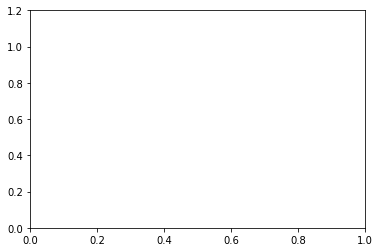

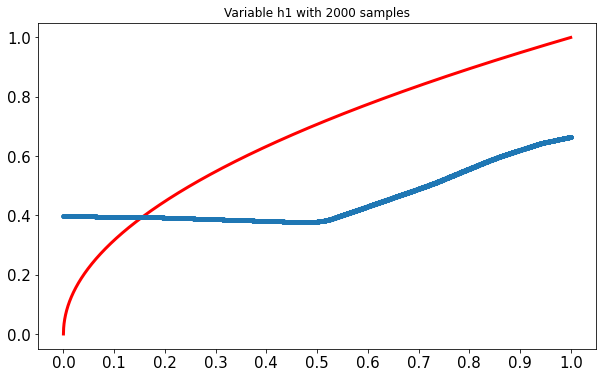

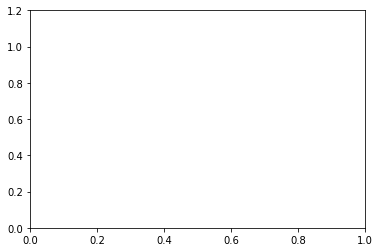

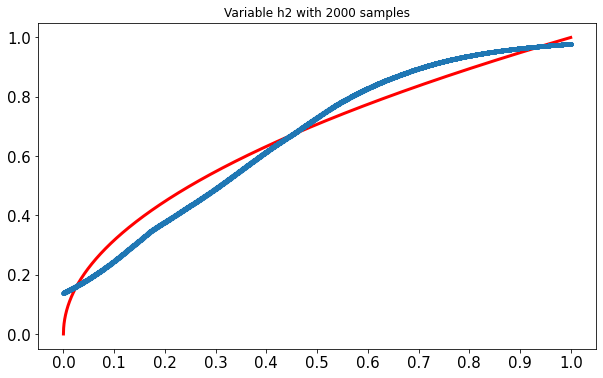

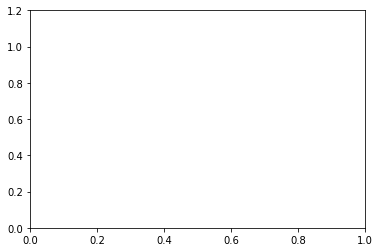

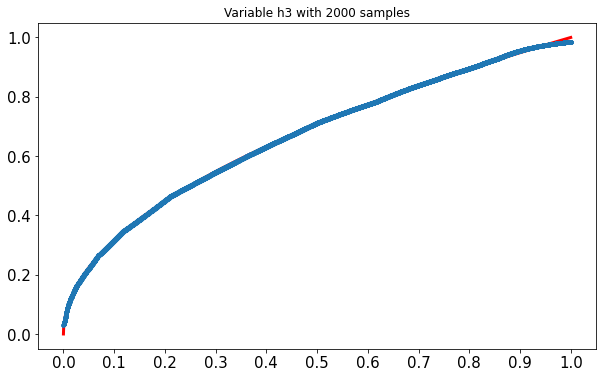

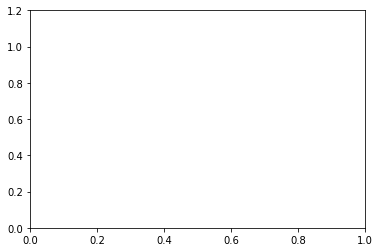

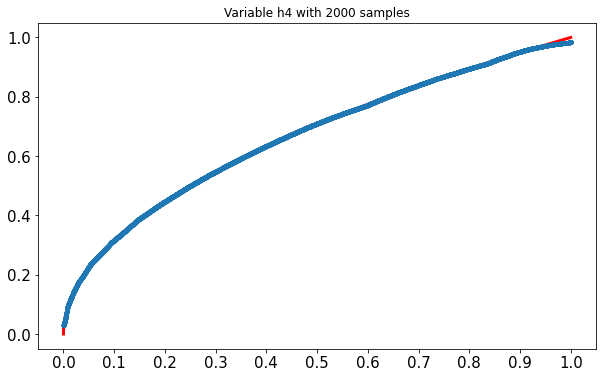

In [26]:
# Single connected 4개 경우의 scatter plot.
import matplotlib.pyplot as plt
N = 10000 # plot N dots

x_grid = np.linspace(0, 1, N+1)
x_grid = x_grid[:-1]
y_grid = np.zeros(N)
ytrue = [myfun(x_grid[i]) for i in range(N)]

y_predict = model1(x_valid.to(device))
y_predict = y_predict.cpu()
y_predict = y_predict.detach().numpy()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h1_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax = plt.gca()
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5)  
plt.scatter(x_grid, y_grid,s=12,zorder=10)
  
plt.title('Variable h1 with '+str(len_data)+' samples')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h2_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax = plt.gca()
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5) 
plt.scatter(x_grid, y_grid,s=12,zorder=10)
   
plt.title('Variable h2 with '+str(len_data)+' samples')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h3_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax = plt.gca()
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red')   

plt.scatter(x_grid, y_grid,s=12,zorder=10)
 
plt.title('Variable h3 with '+str(len_data)+' samples',zorder=5)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h4_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax = plt.gca()
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5)    
plt.scatter(x_grid, y_grid,s=12,zorder=10)

plt.title('Variable h4 with '+str(len_data)+' samples')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


